<a href="https://colab.research.google.com/github/yasirabd/research-diagnostic-turbine/blob/main/Similarity_Based_Modeling_(SBM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Author: Yasir Abdur Rohman*<br>
**Property of PT Indonesia Power & Lab Getaran & Diagnosis Mesin Undip**

---

# Similarity Based Modeling

- Non parametric, empirical modeling technique
- Pattern recognition modality
    - Nonlinear similarity quotient
    - Models combination of the model parameters
- Estimates are derived from interpolating between modeled vectors

# How to Build D Matrix in SBM

Approach:

Combination of Min/Max and Vector Ordering
produces optimal results
1. Select vectors containing the statistical min and
max values for each of the sensor data
2. Compute vector magnitudes (Euclidian distances)
3. Sort the vectors by their magnitudes
4. Select equally spaced N vectors, where N is the
number of vectors remaining to produce a model
(D Matrix) of predetermined size after min/max
selection.

# Estimate using SBM

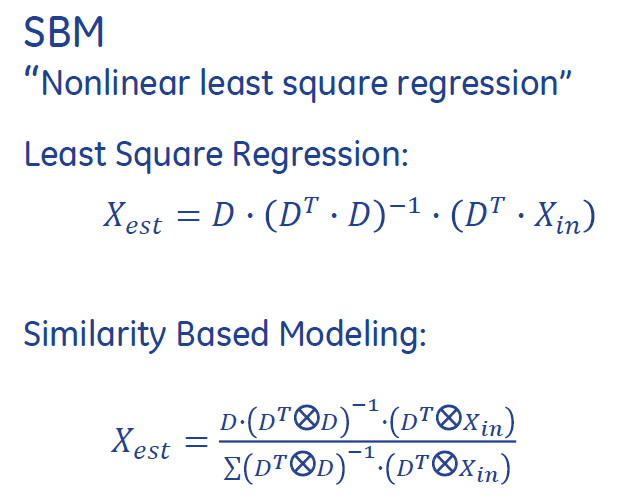

# Code

## Load data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
from scipy.spatial import distance

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Sample Data VBM').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

In [ ]:
data = pd.DataFrame.from_records(rows)
data.columns = data.iloc[0]
data = data[1:]

# convert to numeric
cols = data.columns
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce', axis=1)

data.shape

(400, 5)

In [ ]:
data.head()

,Tag 1,Tag 2,Tag 3,Tag 4,Tag 5
1,374,246,1755,4894,3983
2,420,273,2127,4650,3927
3,376,276,1984,5108,4030
4,371,285,1701,5245,3934
5,386,262,1726,5342,4084


## Build D Matrix
Select vectors containing the statistical `min` and `max` values for each of the sensor data.


In [ ]:
matrix = data.values.T
matrix

array([[ 374,  420,  376, ...,  381,  377,  419],
       [ 246,  273,  276, ...,  262,  247,  273],
       [1755, 2127, 1984, ..., 2326, 2075, 1624],
       [4894, 4650, 5108, ..., 4893, 4622, 5355],
       [3983, 3927, 4030, ..., 4194, 4252, 4251]])

In [ ]:
# calculate min and max for each sensor
vec = []
for m in matrix:
    vec.append(np.array([np.min(m), np.max(m)]))

vec = np.array(vec)
vec

array([[ 370,  420],
       [ 240,  290],
       [1600, 2399],
       [4602, 5399],
       [3901, 4299]])

Compute vector magnitudes (Euclidian distances)

The L2 norm calculates the distance of the vector coordinate from the origin of the vector space. As such, it is also known as the Euclidean norm as it is calculated as the Euclidean distance from the origin. The result is a positive distance value.

https://stackoverflow.com/questions/32141856/is-norm-equivalent-to-euclidean-distance

In [ ]:
from numpy.linalg import norm

magnitude = []
for v in vec:
    l2 = norm(v)
    magnitude.append(l2)

magnitude

[559.7320787662612,
 376.4306044943742,
 2883.6090234288004,
 7094.1951622435645,
 5805.101377237093]

Sort the vectors by their magnitudes

In [ ]:
rank = np.array(magnitude).argsort()
rank

array([1, 0, 2, 4, 3])

In [ ]:
vec = vec[rank]
vec

array([[ 240,  290],
       [ 370,  420],
       [1600, 2399],
       [3901, 4299],
       [4602, 5399]])

Select equally spaced N vectors, where N is the number of vectors remaining to produce a model (D Matrix) of predetermined size after min/max selection.

In [ ]:
N = 5  # equal the number of sensor/tag

D = vec[:N]
D

array([[ 240,  290],
       [ 370,  420],
       [1600, 2399],
       [3901, 4299],
       [4602, 5399]])

## Estimate with SBM

### Least square regression

In [ ]:
# least square regression
def least_square_regression(x_in, D):
    a = np.linalg.inv(np.dot(D.T, D))
    b = np.dot(D.T, x_in)
    c = np.dot(D, a)
    x_est = np.dot(c, b)
    return x_est

In [ ]:
x_in = data.tail(1).values.T
print(f"Xin shape: {x_in.shape}")

x_in

Xin shape: (5, 1)


array([[ 419],
       [ 273],
       [1624],
       [5355],
       [4251]])

In [ ]:
x_est = least_square_regression(x_in, D)
x_est

array([[ 254.77693376],
       [ 420.939487  ],
       [1214.36202442],
       [4572.35653493],
       [5053.51821901]])

In [ ]:
current_actual = np.array([[407, 251, 1890, 5295, 4175]]).T

# sort sensor
current_actual = current_actual[rank]

current_actual

array([[ 251],
       [ 407],
       [1890],
       [4175],
       [5295]])

In [ ]:
x_est = least_square_regression(current_actual, D)
x_est

array([[ 272.06276424],
       [ 411.24165806],
       [1954.54248439],
       [4296.76964981],
       [5167.89964019]])

### Similarity Based Modeling

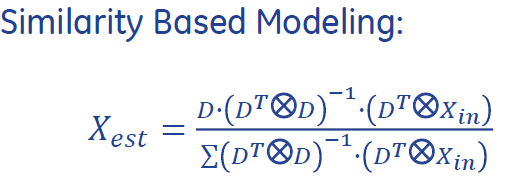

In [ ]:
def sbm(x_in, D):
    a = np.linalg.inv(np.tensordot(D.T, D, axes=1))
    b = np.tensordot(D.T, x_in, axes=1)

    top = np.dot(np.dot(D, a), b)
    bot = np.sum(np.dot(a, b))
    x_est = top/bot
    
    return x_est

In [ ]:
sbm(x_in, D)

array([[ 199.32891462],
       [ 329.32891462],
       [ 950.0760556 ],
       [3577.25816036],
       [3953.70289901]])